#### Lab 8
#### На основе ШАД Яндекс


In [94]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch

### 1. Нахождение сложной производной

Найдите производную по x от функции 
$$\sin\left(\tan(x)\frac{x^2}{y} + \ln(e^{-x^2 + 3}+x^3y)\right)\tan(x^2e^{x^9})$$

При этом надо пользоваться встроенным в PyTorch autograd. Численное вычисление производной может не дать нужный результат.

In [102]:
def find_x_derivative(x, y):
    # YOUR CODE HERE
    dtype = torch.float
    x = torch.tensor(data=x, dtype=dtype, requires_grad=True)
    y = torch.tensor(data=y, dtype=dtype, requires_grad=True)
    derivative = torch.sin(torch.tan(x)*torch.pow(x,2)/y + torch.log(torch.exp(torch.pow(-x,2) + 3) + torch.pow(x,3)*y)) * torch.tan(torch.pow(x,2)*torch.exp(torch.pow(x,9)))
    return derivative.item()

find_x_derivative(1.5, 2)

0.3392165005207062

# 2. Нахождение косинусной близости

Вам даны две матрицы A и B. Необходимо посчитать косинусную близость между строчками матрицы A и столбцами матрицы B. Ответ - матрица чисел, где номер строки - номер строки из матрицы А, а номер столбца - номер столбца из В, от которых бралась косинусная близость.

Напомним, что косинусная близость двух векторов - косинус угла между ними. В n-мерном пространстве косинус угла между веткорами удобнее всего через скалярное произведение:
$$\cos(angle(x, y)) = \frac{x \cdot y}{\left\|x\right\| \left\|y\right\|}$$

(Наша операция очень похожа на умножение матриц)

In [96]:
def get_cos_sim(A, B):
    """
        A, B - torch float tensors
    """
    # YOUR CODE HERE
    a_to_b = torch.mm(A, B)
    a_norm = torch.sqrt(torch.mm(A,A))
    b_norm = torch.sqrt(torch.mm(B,B))
    cos = a_to_b / (a_norm * b_norm)
    return cos

dtype = torch.float
a = torch.tensor([[1, 2], [4, 6]], dtype=dtype)
b = torch.tensor([[0, 2], [8, 10]], dtype=dtype)

get_cos_sim(a, b)

tensor([[1.3333, 1.3148],
        [1.0142, 0.9518]])

# 3. Линейная регрессия

Раньше мы самостоятельно считали производные, чтобы находить веса линейной регрессии с помощью градиентного спуска. Теперь нам нужно использовать для этого PyTorch и его autograd. 

**Важно**: на самом деле .backward не обновляет содержимое матриц с производными (some_tensor.grad), а прибавляет к ним только что посчитаные значения проивзодных. Это значит, что вызвав .backward дважды, вы получите удвоенную производную. Так как мы обновляем веса в цикле и много раз вызываем .backward, то очень быстро мы получим мусор в some_tensor.grad, если не будем его каждый раз обнулять. Таким образом, в конц итериации после использования производных обнулите значения в матрице производных для всех нужных Вам переменных. Делается это вот так 
> some\_tensor.grad.data.zero_()

In [97]:
class LinearRegression:
    def get_loss(self, preds, y):
        """
            @param preds: предсказания модели
            @param y: истиные значения
            @return mse: значение MSE на переданных данных
        """
        # возьмите средний квадрат ошибки по всем выходным переменным
        # то есть сумму квадратов ошибки надо поделить на количество_элементов * количество_таргетов
        mse = torch.mean((preds - y)**2)
        return mse
    
    def init_weights(self, input_size, output_size):
        """
            Инициализирует параметры модели
            W - матрица размерности (input_size, output_size)
            инициализируется рандомными числами из
            uniform распределения (torch.rand())
            b - вектор размерности (1, output_size)
            инициализируется нулями
        """
        torch.manual_seed(0) #необходимо для воспроизводимости результатов
        self.W = torch.rand(input_size, output_size,  requires_grad=True)
        self.b = torch.zeros(1, output_size, requires_grad=True)

    def fit(self, X, y, num_epochs=1000, lr=0.001):
        """
            Обучение модели линейной регрессии методом градиентного спуска
            @param X: размерности (num_samples, input_shape)
            @param y: размерности (num_samples, output_shape)
            @param num_epochs: количество итераций градиентного спуска
            @param lr: шаг градиентного спуска
            @return metrics: вектор значений MSE на каждом шаге градиентного
            спуска.
        """
        self.init_weights(X.shape[1], y.shape[1])
        metrics = []
        for _ in range(num_epochs):
            preds = self.predict(X)
            # сделайте вычисления градиентов c помощью Pytorch и обновите веса
            # осторожнее, оберните вычитание градиента в 
#                 with torch.no_grad():
#                     #some code
            # иначе во время прибавления градиента к переменной создастся очень много нод в дереве операций
            # и ваши модели в будущем будут падать от нехватки памяти
            preds = self.predict(X)
            loss = self.get_loss(preds, y)
            with torch.no_grad():
                loss.backward()
                self.W -= lr * self.W.grad
                self.b -= lr * self.b.grad
            self.W.grad.zero_()
            self.b.grad.zero_()
            metrics.append(self.get_loss(preds, y).data)
        return metrics

    def predict(self, X):
        """
            Думаю, тут все понятно. Сделайте свои предсказания :)
        """
        predict_val = torch.mm(X, self.W) + self.b
        return predict_val

1. Сгенерируйте данные с помощью make_regression с параметрами n_targets=3, n_features=2, noise=10, random_state=42. 
2. Обучите модель линейной регрессии, оставив в fit параметры num_epochs и lr по умолчанию (обратите внимание, что перед обучением нужно привести данные к типу, использующимся в torch) 
2. Посчитайте среднее значение метрики MSE по всем итерациям цикла в fit (массив из значений MSE на каждой итерации возвращается из метода fit). Ответом, который необходимо сдать в систему, будет число, округленное до 3х знаков после запятой.

In [98]:
X, Y = datasets.make_regression(n_targets=3, n_features=2, noise=10, random_state=42)
dtype = torch.float
X = torch.tensor(X, dtype=dtype)
Y = torch.tensor(Y, dtype=dtype)
model = LinearRegression()
mse = model.fit(X, Y)

In [99]:
print(np.mean(mse))

4256.561


Здесь предлагаем протестировать метод predict удобным вам образом.

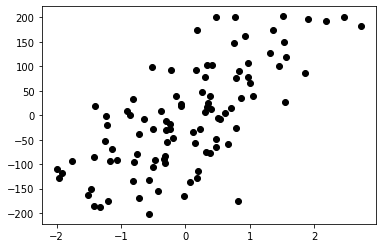

In [100]:
#YOUR CODE
plt.scatter(X[:,0],Y[:,0], color='black', marker='o')

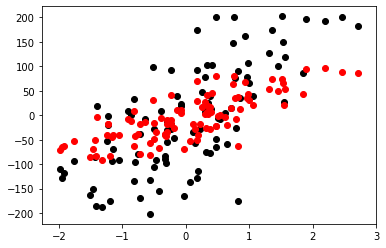

In [101]:
predected=model.predict(X).detach()
expected = X[:,0]
plt.scatter(X[:,0],Y[:,0], color='black', marker='o')
plt.scatter(expected,predected[:,0], color='red')